In [11]:
from sklearn.svm import LinearSVC
from sklearn import preprocessing
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import collections
import seaborn
seaborn.set()

In [12]:
# read names that have provided survey eye color data
columns = ['name', 'timestamp', 'id', 'blood_type', 'height', 'weight', 'hw_comments', 'left', 'right', 'left_desc', 'right_desc', 'eye_comments', 'hair', 'hair_desc', 'hair_comments', 'misc', 'handedness']

# pgp eye color data from survey
surveyData = pd.read_csv("../eye_color_data/PGP-Survey.csv", names=columns, na_values=['nan', '', 'NaN'])

# names of the pgp participants
surveyNames = np.asarray(surveyData['name'].values.tolist())

# load numpy array of tiled PGP data 
pgp = np.load("../hiq-pgp")

In [13]:
eye_color = collections.namedtuple("EyeColor", ['left', 'right'])

# lookup a name in the survey data and return a tuple of the eye colors
def getData(name, surveyData, excludeHazel=True):
    for index, row in surveyData.iterrows():
        if row['name'] == name:
            if not excludeHazel:
                return eye_color(row['left'], row['right'])
            else:
                if isstr(row['left_desc']) and isstr(row['right_desc']):
                    if 'azel' in row['left_desc'] or 'azel' in row['right_desc']:
                        return None
                return eye_color(row['left'], row['right'])

In [14]:
# load numpy array of names and keep only the huID
pgpNames = np.load("../names")
pgpNames = map(lambda name: name[:8], pgpNames)

# simple lambda function to return if the input is a string
isstr = lambda val: isinstance(val, str)

In [15]:
# list of tuples for index and name with eye color data (idx, name)
nameEyeMap = []
namePair = collections.namedtuple("NamePair", ['index', 'name'])

# dictionary of left and right eye colors with respective name, i.e., {"huID": 12}
leftEyeMap = {}
rightEyeMap = {}

existingNames = []

# loop through pgpNames and add eye color to maps, making sure not to add the same name twice
for i, name in enumerate(pgpNames):
    if name in surveyNames and name not in existingNames:
        existingNames.append(name)
        eyeData = getData(name, surveyData, excludeHazel=True)
        if eyeData == None:
            pass
        elif isstr(eyeData.left) and isstr(eyeData.right):
            nameEyeMap.append(namePair(i, name))
            leftEyeMap[name] = eyeData.left
            rightEyeMap[name] = eyeData.right

# create lists containing the known eye color names and the unknown eye colors.
nameIndices, correspondingNames = [], []
for pair in nameEyeMap:
    nameIndices.append(pair.index)
    correspondingNames.append(pair.name)
knownData = pgp[nameIndices]
unknownData = np.delete(pgp, nameIndices, axis=0)

In [16]:
# convert dictionaries to lists 
leftEyeNameList = []
rightEyeNameList = []
# nametuple looks like (index, name)
for _, name in nameEyeMap:
    if isstr(leftEyeMap[name]):
        leftEyeNameList.append(leftEyeMap[name])
    if isstr(rightEyeMap[name]):
        rightEyeNameList.append(rightEyeMap[name])

blueOrNot = lambda color: 0 if int(color) > 13 else 1
leftEyeNameList = map(blueOrNot, leftEyeNameList)

In [17]:
def getDiff(number): # these values are from the retrieve tile variant script
    if number == 0 or number == 2 or number == 4:
        return "a"
    elif number == 1 or number == 3 or number == 5:
        return "g"
    else:
        return other
    
def getEyeColor(number):
    if number == 0:
        return "not blue"
    else:
        return "blue"

In [18]:
results = []
# tile with index 1792420 had highest coefficient.
# upon checking 1792420, appeared to be the other phase of the same tile.
for i, genome in enumerate(knownData):
    result = getDiff(genome[1792420]) + " " + getDiff(genome[1792421]) + " " + getEyeColor(leftEyeNameList[i])
    results.append(result)

In [19]:
# get results from the phasing data
# https://www.snpedia.com/index.php/rs12913832
blueAG, blueGG, blueAA = 0, 0, 0
notBlueAG, notBlueGG, notBlueAA = 0, 0, 0
for result in results:
    if "a g not blue" in result:
        notBlueAG += 1
    elif "a g blue" in result:
        blueAG += 1 
    elif "g g blue" in result:
        blueGG += 1
    elif "g g not blue" in result:
        notBlueGG += 1
    elif "a a not blue" in result:
        notBlueAA += 1
    elif "a a blue" in result:
        blueAA += 1
    

print "Blue AA", str(blueAA) + ", Not Blue AA", str(notBlueAA)
print "Blue AG", str(blueAG) + ", Not Blue AG", str(notBlueAG)
print "Blue GG", str(blueGG) + ", Not Blue GG", str(notBlueGG)

Blue AA 0, Not Blue AA 4
Blue AG 3, Not Blue AG 21
Blue GG 33, Not Blue GG 0


In [20]:
'''
Fisher Exact Test - we avoid AA because there are too few samples.
            GG        AG
Blue        blueGG    blueAG

Not Blue    notBlueGG notBlueAG
'''
import scipy.stats as stats
fisher_table = np.asarray([[blueGG, blueAG], [notBlueGG, notBlueAG]])
print fisher_table
oddsratio, pvalue = stats.fisher_exact(fisher_table)
print "P value:", pvalue

[[33  3]
 [ 0 21]]
P value: 9.4917430966e-13


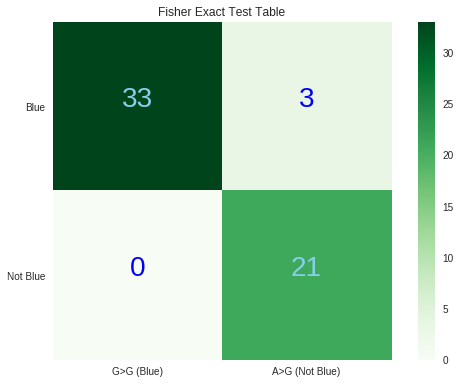

In [27]:
plt.imshow(fisher_table, interpolation='nearest', cmap=plt.cm.Greens)

classes = ['Blue','Not Blue']
genotypes = ['G>G (Blue)', 'A>G (Not Blue)']
plt.title("Fisher Exact Test Table")
plt.grid('off')
plt.colorbar()
tick_marks_y = np.arange(len(classes))
tick_marks_x = np.arange(len(genotypes))

plt.xticks(tick_marks_x, genotypes)
plt.yticks(tick_marks_y, classes)

for i in range(fisher_table.shape[0]):
    for j in range(fisher_table.shape[1]):
        if fisher_table[i, j] > 20:
            plt.text(j, i, fisher_table[i, j],
                     horizontalalignment="center",
                     fontsize=28,
                     color="skyblue")
        else:
            plt.text(j, i, fisher_table[i, j],
                     horizontalalignment="center",
                     fontsize=28,
                     color="blue")

plt.gcf().subplots_adjust(left=0.25, bottom = 0.35)
plt.tight_layout()
plt.savefig('../images/fisher_table.png',format='png',dpi=900, transparent=True)